In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import xarray as xr
import math as math
from scipy.optimize import curve_fit
import seaborn as sns
plt.style.use('seaborn')

C:\Users\pkoll\AppData\Local\Temp\ipykernel_6732\1272907536.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
dsm  = xr.open_dataset('eqcross_mv05iv06_r01_mti_2021.nc')
dsi  = xr.open_dataset('eqcross_mv05iv06_r01_ivm_2021 (1).nc')

dsi = dsi.load()

C:\Users\pkoll\anaconda3\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
dsm

<xarray.Dataset>
Dimensions:    (num: 7594, dt: 33, alt: 84)
Coordinates:
  * alt        (alt) float64 88.38 91.33 94.28 97.21 ... 297.7 300.0 302.3 304.6
  * dt         (dt) float64 -480.0 -450.0 -420.0 -390.0 ... 420.0 450.0 480.0
  * num        (num) int64 0 1 2 3 4 5 6 ... 7587 7588 7589 7590 7591 7592 7593
Data variables: (12/35)
    u          (num, dt, alt) float64 ...
    v          (num, dt, alt) float64 ...
    lon        (num, dt) float64 ...
    lat        (num, dt) float64 ...
    u_error    (num, dt, alt) float64 ...
    v_error    (num, dt, alt) float64 ...
    ...         ...
    Ue1P       (num) float64 ...
    Ue2P       (num) float64 ...
    Ue1H_err   (num) float64 ...
    Ue2H_err   (num) float64 ...
    Ue1P_err   (num) float64 ...
    Ue2P_err   (num) float64 ...

In [4]:
dsi

<xarray.Dataset>
Dimensions:    (dt: 961, num: 7594)
Coordinates:
  * dt         (dt) float64 -480.0 -479.0 -478.0 -477.0 ... 478.0 479.0 480.0
  * num        (num) int64 0 1 2 3 4 5 6 ... 7587 7588 7589 7590 7591 7592 7593
Data variables: (12/17)
    time       (num, dt) datetime64[ns] 2021-01-01T00:19:39.488000 ... 2021-1...
    ni         (num, dt) float64 3.532e+04 3.532e+04 ... 3.005e+04 2.999e+04
    Ti         (num, dt) float64 2.518e+03 2.519e+03 2.52e+03 ... 771.7 771.7
    mag_lat    (num, dt) float32 9.862 9.843 9.824 9.805 ... -14.75 -14.77 -14.8
    mag_lon    (num, dt) float32 327.1 327.1 327.2 327.2 ... 213.5 213.6 213.7
    apex_ht    (num, dt) float32 808.8 808.0 807.1 ... 1.084e+03 1.086e+03
    ...         ...
    alt        (num, dt) float32 600.4 600.4 600.4 600.4 ... 598.2 598.2 598.1
    slt        (num, dt) float32 17.27 17.27 17.27 17.28 ... 3.689 3.693 3.697
    sza        (num, dt) float32 80.64 80.68 80.72 80.76 ... 118.5 118.4 118.4
    dm_flag    (num, dt) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    rpa_flag   (num, dt) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    op_frac    (num, dt) float64 0.6378 0.6386 0.6395 ... 0.447 0.4492 0.4446

#### Conductivity Weighted Winds

In [5]:
#Ue1P (Pedersen-conductivity-weighted zonal wind)
dsm.Ue1P

<xarray.DataArray 'Ue1P' (num: 7594)>
[7594 values with dtype=float64]
Coordinates:
  * num      (num) int64 0 1 2 3 4 5 6 7 ... 7587 7588 7589 7590 7591 7592 7593

In [6]:
dsm.Ue1H

<xarray.DataArray 'Ue1H' (num: 7594)>
[7594 values with dtype=float64]
Coordinates:
  * num      (num) int64 0 1 2 3 4 5 6 7 ... 7587 7588 7589 7590 7591 7592 7593

In [7]:
dm0 = dsm[['u','v', 'Ue1H','Ue1P','t_temp']].sel(dt=slice(-45,45)).mean(dim= 'dt').isel(alt=slice(2,-2)) # Only u, v, Hall variables
di0 = dsi[['drift_mer','slt','dm_flag', 'rpa_flag']].sel(dt=slice(-45,45)).mean(dim = 'dt')# only use drift_mer variable (but also save other variables for context: local time, actual time, IVM data quality flags)
dt0 = dsi[['time']]

d = xr.merge((dm0, di0, dt0))
d = d.dropna(dim='num', how='any', subset=['u','drift_mer','Ue1H','Ue1P']) # Drop missing data

# Only keep data where the ivm quality flag is good
d = d.where((d.slt > 8) & (d.slt < 16) & (d.dm_flag == 0) & (d.rpa_flag == 0), drop=True)
#d['time'] = pd.to_datetime('1989-04-18') + pd.to_timedelta(d['t_temp'].values[0], unit='s')

In [8]:
d

<xarray.Dataset>
Dimensions:    (num: 1633, alt: 80, dt: 961)
Coordinates:
  * alt        (alt) float64 94.28 97.21 100.1 103.1 ... 293.1 295.4 297.7 300.0
  * num        (num) int64 10 11 21 22 23 28 ... 7574 7576 7577 7582 7584 7586
  * dt         (dt) float64 -480.0 -479.0 -478.0 -477.0 ... 478.0 479.0 480.0
Data variables:
    u          (num, alt) float64 -68.29 -30.98 19.07 ... -9.639 -17.42 -25.18
    v          (num, alt) float64 88.07 117.0 89.5 24.04 ... 79.81 85.59 91.35
    Ue1H       (num) float64 7.855 -3.031 6.361 -0.6427 ... -47.54 -43.05 -20.58
    Ue1P       (num) float64 -21.39 -21.37 -18.78 ... -19.78 -0.1078 -9.584
    t_temp     (num, alt) float64 1.001e+09 1.001e+09 ... 1.032e+09 1.032e+09
    drift_mer  (num) float64 -1.021 -0.3412 2.802 -6.947 ... 22.22 26.88 25.06
    slt        (num) float32 15.88 15.69 15.85 15.91 ... 15.85 15.99 15.92 15.89
    dm_flag    (num) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    rpa_flag   (num) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    time       (num, dt) datetime64[ns] 2021-01-01T14:33:48.131000 ... 2021-1...

In [9]:
# This will save all of the changes between the pairs.

delta_t_hr = [] 
delta_alt = [] 
delta_u = [] 
delta_drift_mer = []
delta_slt = [] 
delta_uh = []
delta_up = []

for i in range(len(d.num)):
    # Status indicator
    if np.mod(i,10) == 0:
        print('%i / %i' % (i, len(d.num)))
    
    ds1 = d.isel(num=i)
    
    # Grab all other timestamps that are 24-24.15 hours in the future, collect them in dataset ds2
    delta_t = d.time - ds1.time 
    happens_soon_after = (delta_t > pd.to_timedelta('24h')) & (delta_t < pd.to_timedelta('24.15h'))
    ds2 = d.where(happens_soon_after, drop=True)
        
    # Record some parameters of interest.
    #delta_t_hr.extend(pd.to_timedelta(ds2.time - ds1.time).total_seconds()/3600.)
    #delta_alt.extend(ds2.alt - ds1.alt)
    delta_u.extend(ds2.u - ds1.u)
    delta_drift_mer.extend(ds2.drift_mer - ds1.drift_mer)
    delta_uh.extend(ds2.Ue1H - ds1.Ue1H)
    delta_up.extend(ds2.Ue1P - ds1.Ue1P)
    #delta_slt.extend(np.mod(ds2.slt - ds1.slt + 12, 24) - 12) # Similar for local times (-12 to +12)
    
#delta_t_hr = np.array(delta_t_hr) #should all be between 24-24.15
#delta_alt = np.array(delta_alt) #should all be 0
delta_u = np.array(delta_u)
delta_drift_mer = np.array(delta_drift_mer)
delta_uh = np.array(delta_uh)
delta_up = np.array(delta_up)
#delta_slt = np.array(delta_slt) #not really needed for analysis

0 / 1633
10 / 1633
20 / 1633
30 / 1633
40 / 1633
50 / 1633
60 / 1633
70 / 1633
80 / 1633
90 / 1633
100 / 1633
110 / 1633
120 / 1633
130 / 1633
140 / 1633
150 / 1633
160 / 1633
170 / 1633
180 / 1633
190 / 1633
200 / 1633
210 / 1633
220 / 1633
230 / 1633
240 / 1633
250 / 1633
260 / 1633
270 / 1633
280 / 1633
290 / 1633
300 / 1633
310 / 1633
320 / 1633
330 / 1633
340 / 1633
350 / 1633
360 / 1633
370 / 1633
380 / 1633
390 / 1633
400 / 1633
410 / 1633
420 / 1633
430 / 1633
440 / 1633
450 / 1633
460 / 1633
470 / 1633
480 / 1633
490 / 1633
500 / 1633
510 / 1633
520 / 1633
530 / 1633
540 / 1633
550 / 1633
560 / 1633
570 / 1633
580 / 1633
590 / 1633
600 / 1633
610 / 1633
620 / 1633
630 / 1633
640 / 1633
650 / 1633
660 / 1633
670 / 1633
680 / 1633
690 / 1633
700 / 1633
710 / 1633
720 / 1633
730 / 1633
740 / 1633
750 / 1633
760 / 1633
770 / 1633
780 / 1633
790 / 1633
800 / 1633
810 / 1633
820 / 1633
830 / 1633
840 / 1633
850 / 1633
860 / 1633
870 / 1633
880 / 1633
890 / 1633
900 / 1633
910 / 1633

In [10]:
df_u = pd.DataFrame(delta_u[:,:,0])
df_drift_mer = pd.DataFrame(delta_drift_mer[:,0])
df_hall = pd.DataFrame(delta_uh[:,0])
df_peterson = pd.DataFrame(delta_up[:,0])

In [11]:
df_X = pd.DataFrame()
df_X['Hall'] = df_hall[0]
df_X['Peterson'] = df_peterson[0]

In [14]:
df_X

,Hall,Peterson
0,-0.456147,1.738997
1,2.342483,19.528840
2,25.044186,3.297438
3,-7.785607,4.598325
4,3.754798,-1.867307
...,...,...
1318,15.114654,14.679765
1319,-21.893273,-0.745124
1320,-1.135624,-10.402794
1321,-34.437827,-24.491402


In [15]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import train_test_split

X = df_X
X.columns = X.columns.astype(str)
y = df_drift_mer


In [28]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

from sklearn.metrics import r2_score
r2_train_sk = r2_score(y_train, y_train_pred)
r2_test_sk = r2_score(y_test, y_test_pred)

In [34]:
np.shape(X)

(1323, 2)

In [44]:
print(model.coef_[0])
np.shape(model.coef_[0])

[-0.2550325   0.14467185]


(2,)

In [67]:
d = dsm[['ue1h_coef','ue1p_coef']].mean(dim = 'num').isel(alt=slice(2,-2))# Only Hall,Peterson variables
weight = d.to_array()
d_W = pd.DataFrame(weight)

np.shape(d_W)

(2, 80)

In [71]:
# C.T dot A dot del_u
A = d_W.T.dot(model.coef_[0])
print(np.shape(A))

(80,)


<IPython.core.display.Javascript object>


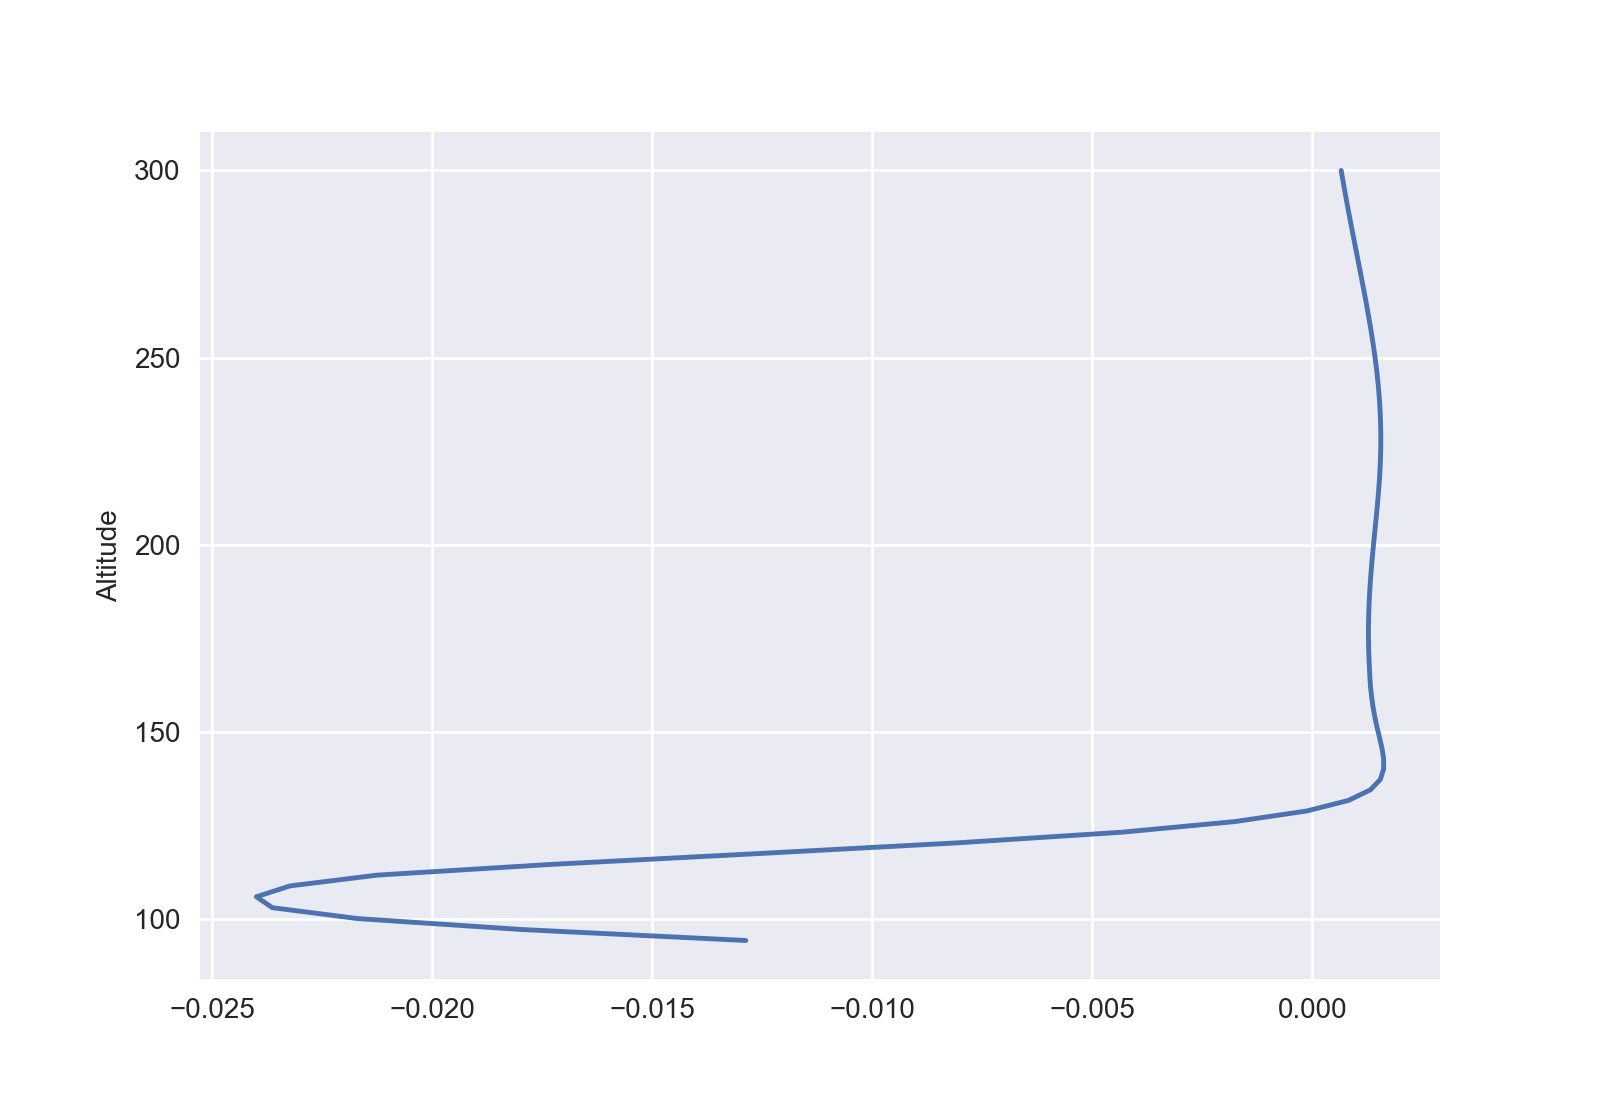

In [75]:
plt.figure()
plt.plot(A,d.alt)
plt.ylabel('Altitude')
plt.show()

<IPython.core.display.Javascript object>


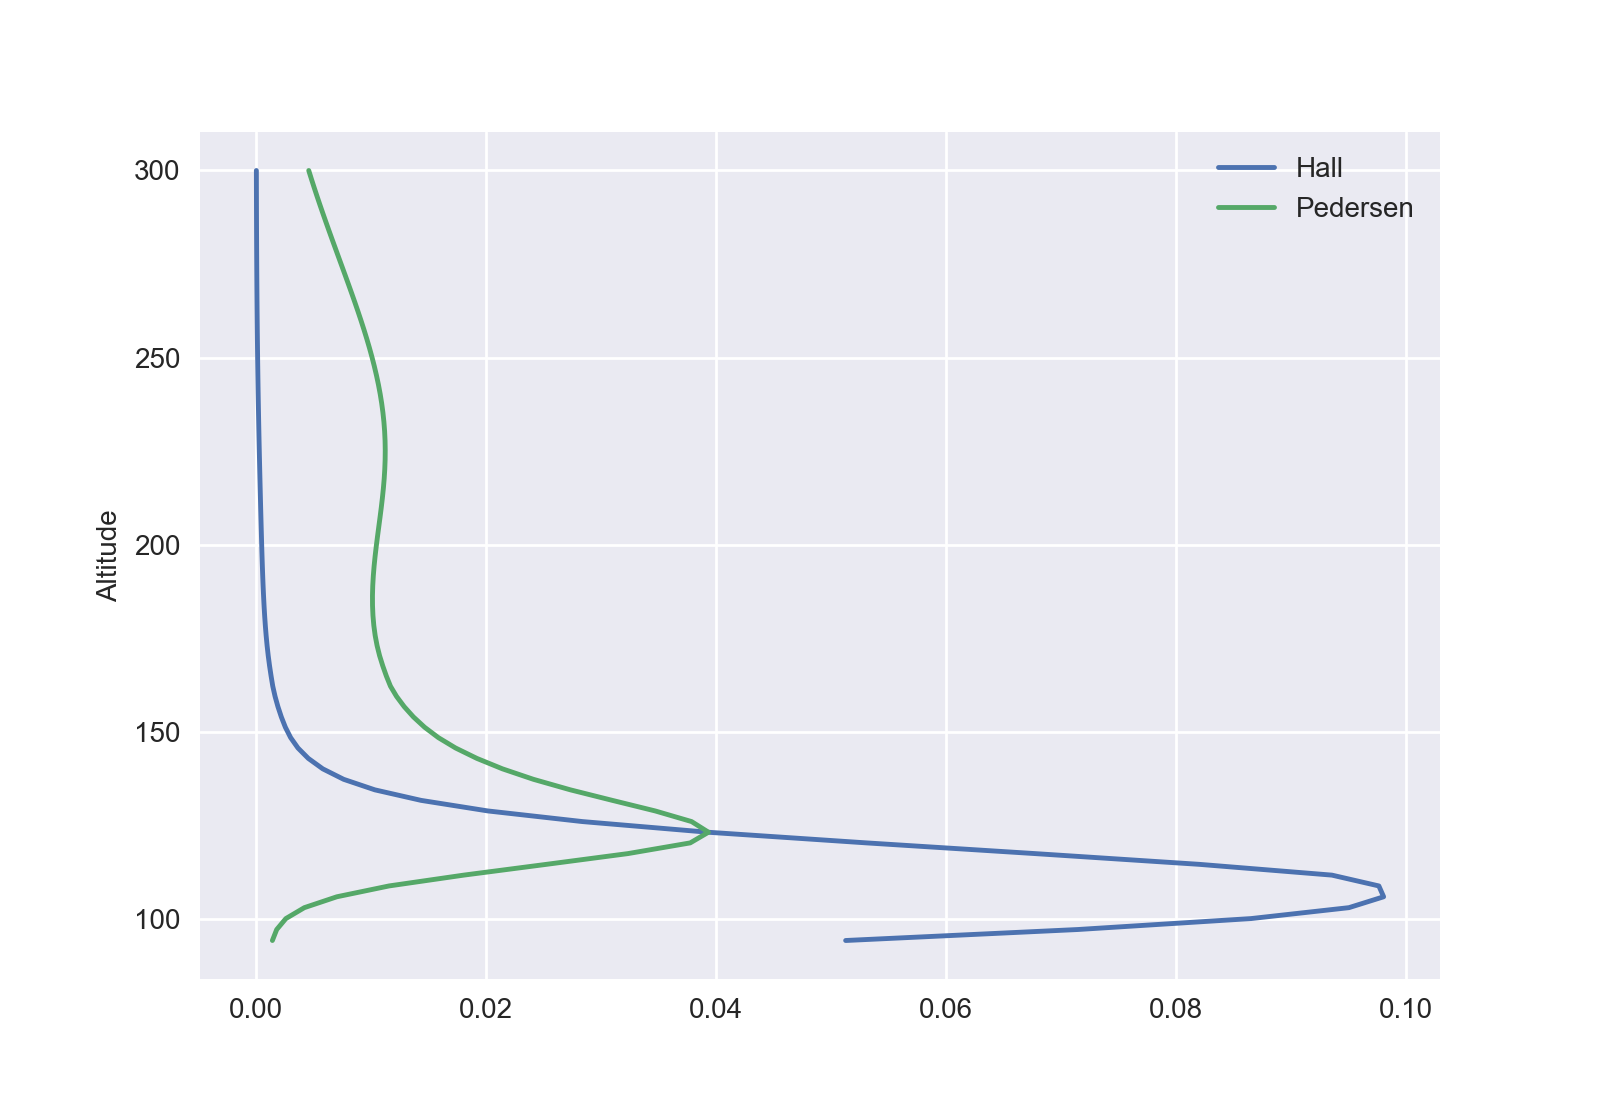

In [79]:
plt.figure()
plt.plot(weight[0],d.alt, label = 'Hall')
plt.plot(weight[1],d.alt, label = 'Pedersen')
plt.ylabel('Altitude')
plt.legend()
plt.show()